[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.debugger import set_trace
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# Data Preprocessing

In [ ]:
## packaging it all into a function
def preprocess_fashion_mnist():
  import random as rand
   
   
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  mean_mat = np.mean(x_train, axis=0)
  
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat
  
  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  #finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)
  
  return x_train, y_train, x_test, y_test
# x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

# Model Implementation - SoftMax


**Activation functions**

In [ ]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))

# Tanh
tanh = lambda x: 2./ (1+np.exp(-2*x)) -1
tanh_grad = lambda x: 1 - np.square(2./ (1+np.exp(-2*x)) -1)

# Leaky ReLu
def leaky_relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x

def leaky_relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

  
# ReLu
def relu(x):
  x=np.array(x).astype(float)
  np.putmask(x, x<0, 0)
  return x
  
def relu_grad(x):
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=0
  return x

Dimension Indications

Accuracy function

In [ ]:
def evaluate_acc(pred, truth):
  counter =0
  
  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter * 100.0 / float(len(pred))
  

# Model - Leaky ReLu

In [ ]:
class MLPLeakyRelu:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = leaky_relu(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = leaky_relu(q2)
            # print("z2=", z2.shape)

            # print("np.dot(z, w)=",np.dot(z, w).shape)
            yh = softmax2D(np.dot(z2, w))#N
            
            # #get accuracy based on predictions
            acc = evaluate_acc(yh,y)
            
            ## Backpropagation
            
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            
            ## 2nd Layer     
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * leaky_relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * leaky_relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            
            return dparams, acc

        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params, batch_acc = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self, batch_acc
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Batch Implementation

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [ ]:
def mini_batcher(x, y, mini_batch_size):
  zipped = np.hstack( (x, y ) )
  np.random.shuffle(zipped)
  x_batches, y_batches = [], []
  mini_batches = []
  batch_num = x.shape[0] // mini_batch_size 
  for i in range(batch_num):
    x_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, :-10]
    y_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, -10:]
    mini_batches.append( ( x_batch, y_batch) )
  if x.shape[0] % mini_batch_size != 0:
    x_batch = zipped[ batch_num * mini_batch_size :, :-10]
    y_batch = zipped[ batch_num * mini_batch_size :, -10:]
    mini_batches.append( ( x_batch, y_batch ) )
  return mini_batches

# Gradient Descent 

---



In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=800, epsilon=1e-8, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            print(grad[1])
            print(params[1])
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            print(params[1])
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])

        print(t)
        return params
    
    def run_mini_batch(self, gradient_fn, x, y, params, batch_size=32):
        norms = np.array([np.inf])
        t=1
        temp_acc,batch_acc, chunk= [], [], []
        mini_batches = mini_batcher(x, y, batch_size)
        batch_index = 0

        while np.any(norms > self.epsilon) and t < self.max_iters*len(mini_batches):
            
            if(batch_index == batch_size):
              mini_batches = mini_batcher(x, y, batch_size)
              batch_index = 0
            batch_index +=1

            x_temp, y_temp = mini_batches[t % ( len(mini_batches)-1 ) ][0], mini_batches[t % ( len(mini_batches)-1 ) ][1]
            grad, temp_acc = gradient_fn(x_temp, y_temp, params)
            chunk.append(temp_acc)
            if t % 10000 == 0:
              print(f"Epoch{t}:{temp_acc}%")

            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            if t%len(mini_batches) == 2:
              batch_acc.append(np.mean(chunk))
              chunk = []
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params, batch_acc

# MNIST DataSet

In [ ]:
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()
model2 = MLPLeakyRelu(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002, batch_size=32, max_iters=2e3)
y_pred2, batch_acc = model2.fit(x_train[:10000], y_train[:10000], optimizer)

Epoch10000:12.5%
Epoch20000:28.125%
Epoch30000:34.375%
Epoch40000:46.875%
Epoch50000:46.875%
Epoch60000:40.625%
Epoch70000:50.0%
Epoch80000:53.125%
Epoch90000:50.0%
Epoch100000:46.875%
Epoch110000:59.375%
Epoch120000:56.25%
Epoch130000:62.5%
Epoch140000:65.625%
Epoch150000:46.875%
Epoch160000:65.625%
Epoch170000:50.0%
Epoch180000:62.5%
Epoch190000:71.875%
Epoch200000:50.0%
Epoch210000:65.625%
Epoch220000:62.5%
Epoch230000:71.875%
Epoch240000:68.75%
Epoch250000:75.0%
Epoch260000:56.25%
Epoch270000:59.375%
Epoch280000:68.75%
Epoch290000:75.0%
Epoch300000:81.25%
Epoch310000:75.0%
Epoch320000:78.125%
Epoch330000:71.875%
Epoch340000:84.375%
Epoch350000:71.875%
Epoch360000:65.625%
Epoch370000:68.75%
Epoch380000:68.75%
Epoch390000:68.75%
Epoch400000:78.125%
Epoch410000:68.75%
Epoch420000:62.5%
Epoch430000:59.375%
Epoch440000:78.125%
Epoch450000:71.875%
Epoch460000:84.375%
Epoch470000:62.5%
Epoch480000:62.5%
Epoch490000:56.25%
Epoch500000:68.75%
Epoch510000:81.25%
Epoch520000:71.875%
Epoch5300

Number of full training batch iterations: 2000
Accuracies per training batch:
12.5
15.05591054313099
14.966054313099042
14.886182108626198
14.996006389776358
15.555111821086262
15.475239616613418
15.784744408945686
15.824680511182109
16.34384984025559
16.533546325878593
16.833067092651756
16.5435303514377
16.403753993610223
17.292332268370608
16.882987220447284
17.382188498402556
18.011182108626198
18.081070287539937
18.210862619808307
17.81150159744409
18.31070287539936
18.560303514376997
19.109424920127797
18.650159744408946
18.500399361022364
19.309105431309906
19.518769968051117
19.49880191693291
21.17611821086262
19.768370607028753
20.746805111821086
20.107827476038338
20.626996805111823
21.106230031948883
20.836661341853034
21.11621405750799
21.28594249201278
22.214456869009584
21.705271565495206
22.134584664536742
22.344249201277954
22.454073482428115
22.134584664536742
22.20447284345048
23.49241214057508
22.923322683706072
22.963258785942493
24.361022364217252
23.52236421725239

No handles with labels found to put in legend.


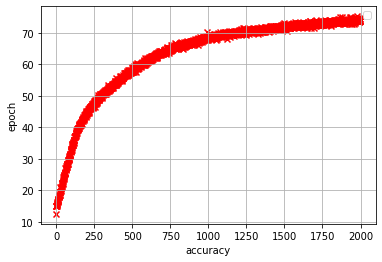

72.81


In [ ]:
y_test_pred2 = model2.predict(x_test)

print("Number of full training batch iterations:",len(batch_acc))
print("Accuracies per training batch:")
for i in batch_acc:
  print(i)
print("---------")
fig, ax = plt.subplots()
ax.scatter(range(len(batch_acc)), batch_acc, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.show()
print(evaluate_acc(y_test_pred2, y_test))

In [ ]:
evaluate_acc(y_test_pred2, y_test)

72.81